In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# torch.manual_seed(1)
# np.random.seed(1)

In [3]:
# Hyper Parameters
BATCH_SIZE = 64
LR_G = 0.0001        # learning rate for generator
LR_D = 0.0001        # learning rate for discriminator
N_IDEAS = 5          # think of this as number of ideas for generating an art work (Generator)
ART_COMPONENTS = 15  # it could be total point G can draw in the canvas
PAINT_POINTS = np.vstack([np.linspace(-1, 1, ART_COMPONENTS) for _ in range(BATCH_SIZE)])

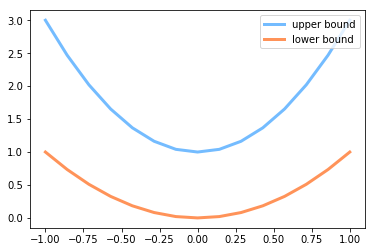

In [6]:
# show our beautiful painting range
plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='upper bound')
plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + 0, c='#FF9359', lw=3, label='lower bound')
plt.legend(loc='upper right')
plt.show()

In [18]:
def artist_works_with_labels():   # painting from the famous artist (real target)
    a = np.random.uniform(1, 2, size=BATCH_SIZE)[:, np.newaxis]
    paintings = a * np.power(PAINT_POINTS, 2) + (a-1)
    labels = (a-1) > 0.5          # upper paintings (1), lower paintings (0), two classes
    paintings = torch.from_numpy(paintings).float()
    labels = torch.from_numpy(labels.astype(np.float32))
    return paintings, labels

G = nn.Sequential(                      # Generator
    nn.Linear(N_IDEAS+1, 128),            # random ideas (could from normal distribution)
    nn.ReLU(),
    nn.Linear(128, ART_COMPONENTS),     # making a painting from these random ideas
)

D = nn.Sequential(                      # Discriminator
    nn.Linear(ART_COMPONENTS+1, 128),     # receive art work either from the famous artist or a newbie like G
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid(),                       # tell the probability that the art work is made by artist
)

In [19]:
opt_D = torch.optim.Adam(D.parameters(), lr=LR_D)
opt_G = torch.optim.Adam(G.parameters(), lr=LR_G)

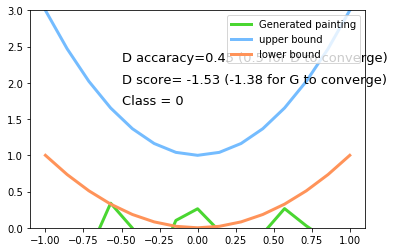

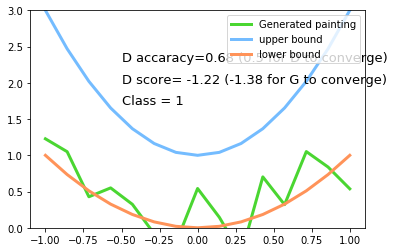

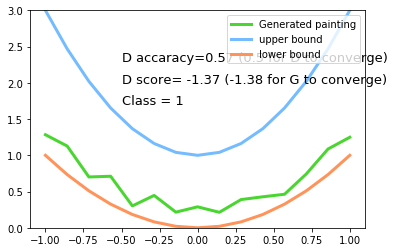

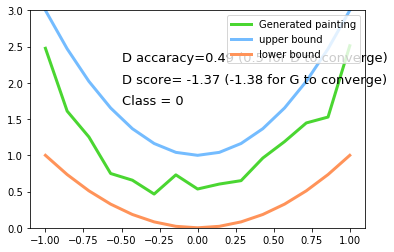

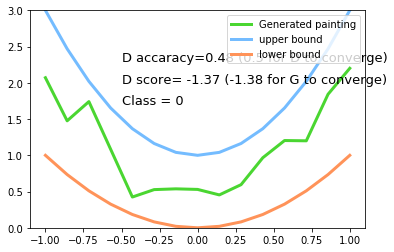

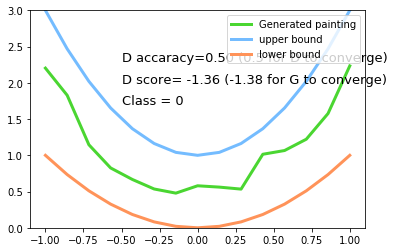

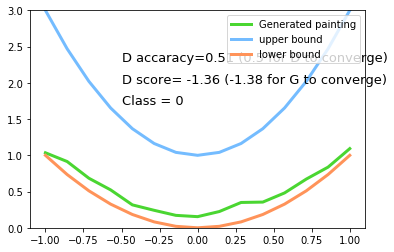

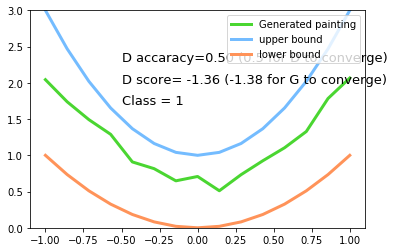

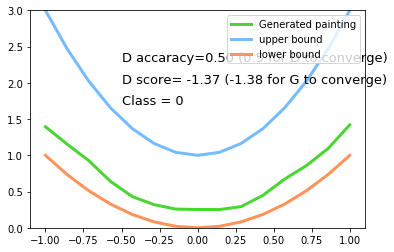

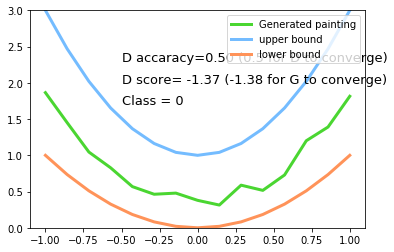

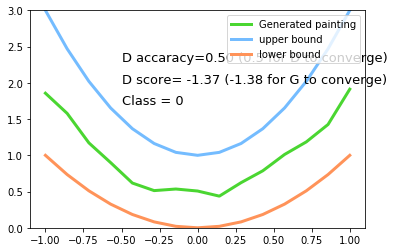

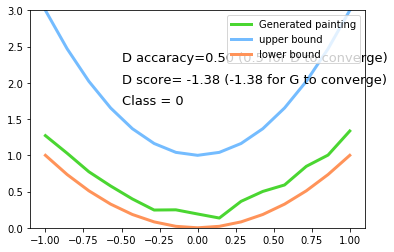

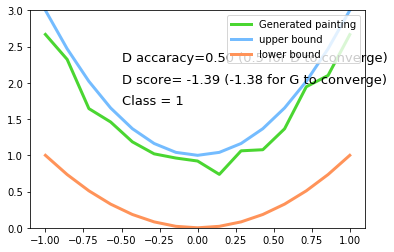

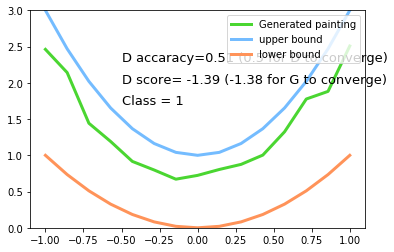

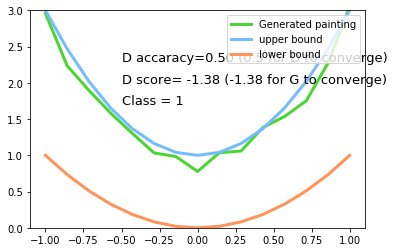

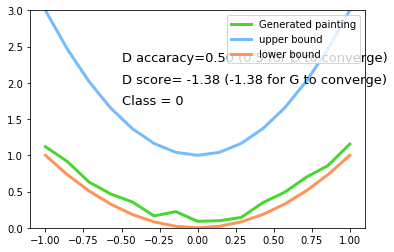

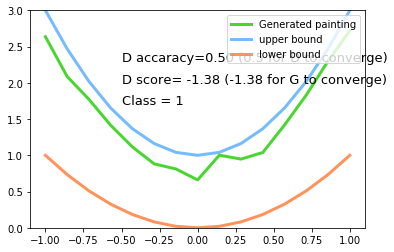

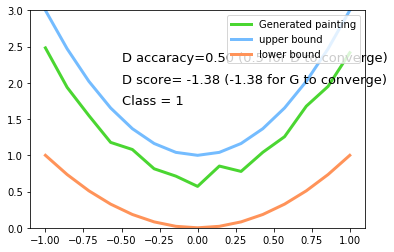

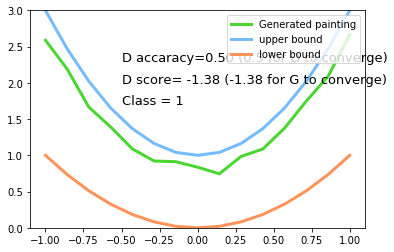

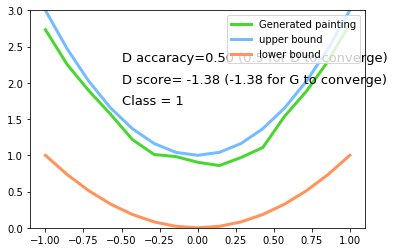

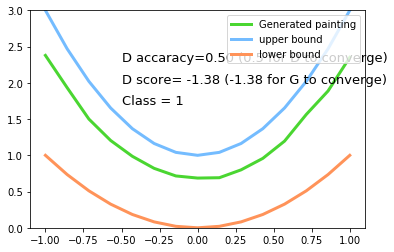

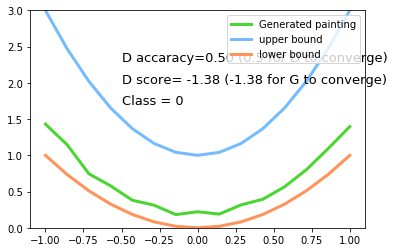

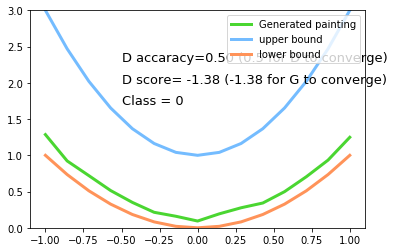

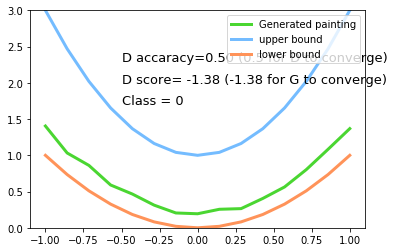

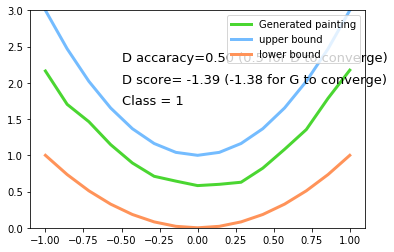

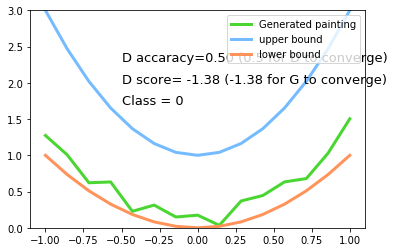

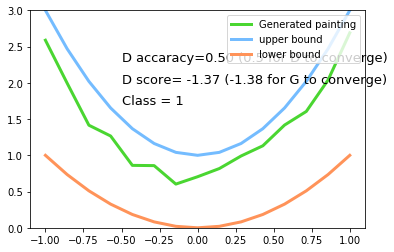

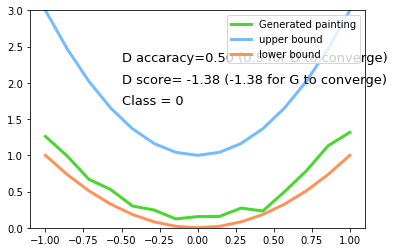

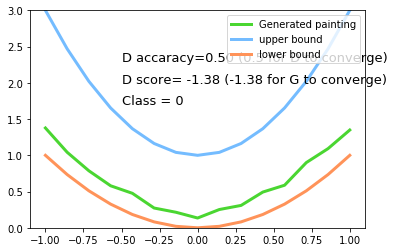

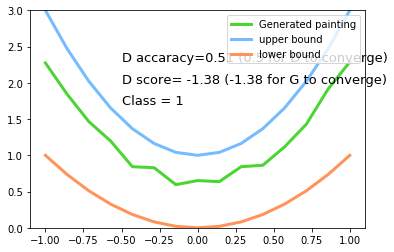

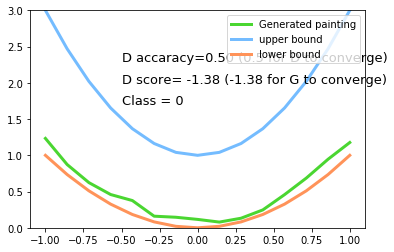

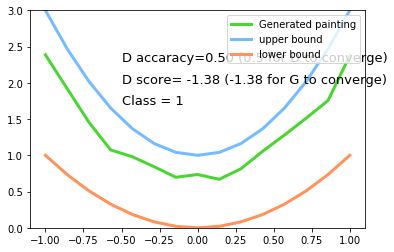

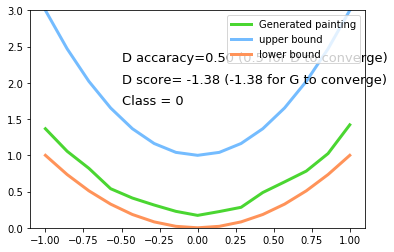

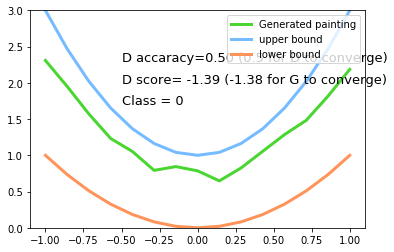

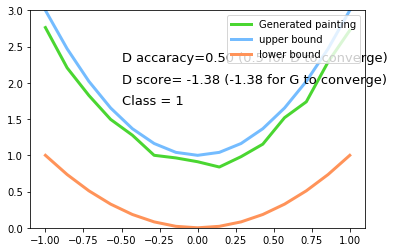

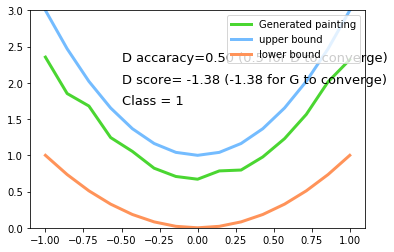

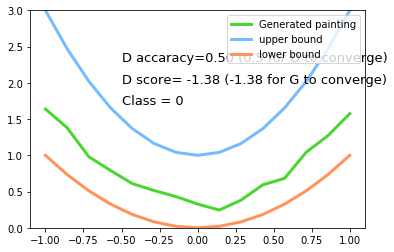

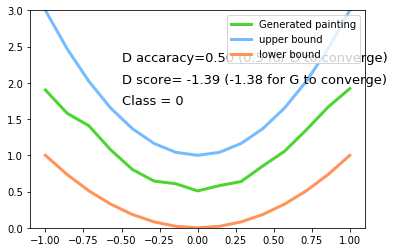

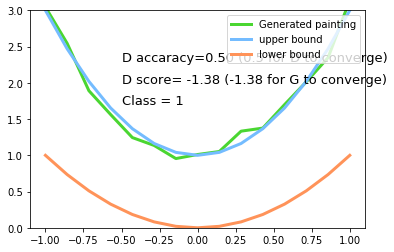

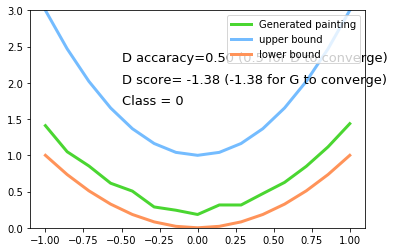

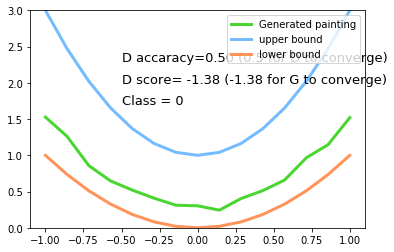

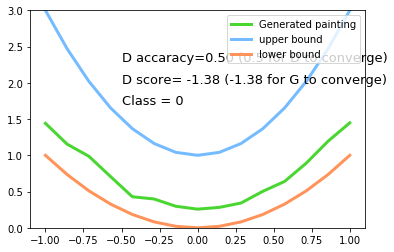

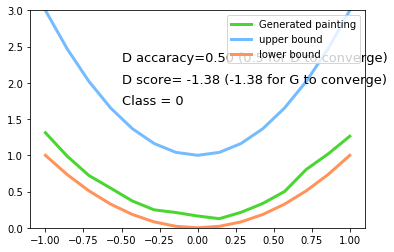

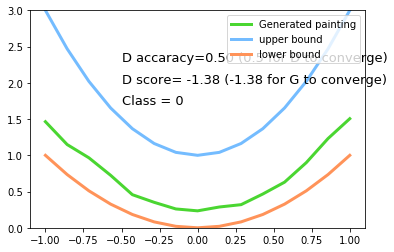

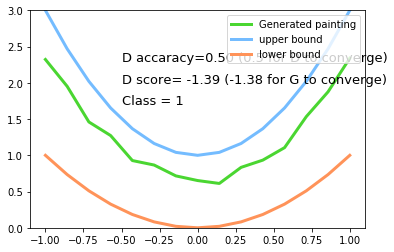

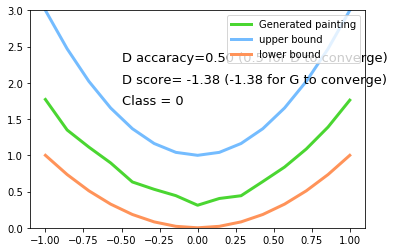

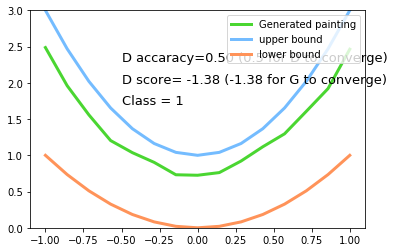

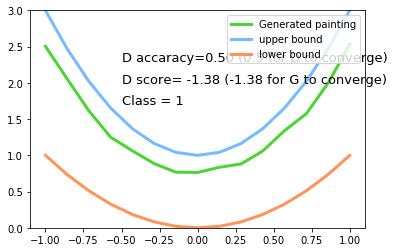

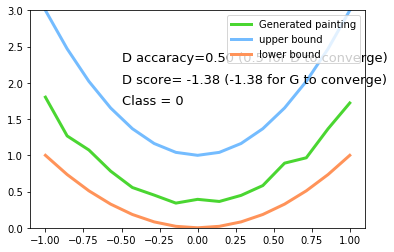

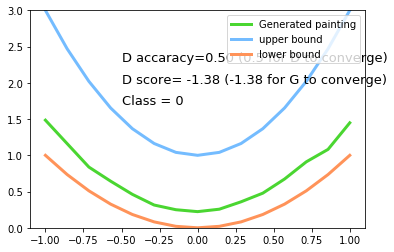

In [24]:
plt.ion() # somthing about continuous plotting

for step in range(10000):
    artist_paintings, labels = artist_works_with_labels()       # real painting from artist
    G_ideas = torch.randn(BATCH_SIZE, N_IDEAS)                  # random ideas
    G_inputs = torch.cat((G_ideas, labels), 1)                  # ideas with labels
    G_paintings = G(G_inputs)                                   # fake painting w.r.t label from G
    
    D_inputs0 = torch.cat((artist_paintings, labels), 1)        # all have their labels
    D_inputs1 = torch.cat((G_paintings, labels), 1)
    prob_artist0 = D(D_inputs0)          # D try to increase this prob
    prob_artist1 = D(D_inputs1)          # D trt to reduce this prob
    
    D_score0 = torch.log(prob_artist0)          # maximise this for D
    D_score1 = torch.log(1. - prob_artist1)     # maximise this for D
    D_loss = - torch.mean(D_score0 + D_score1)  # minimise the negative of both two above for D
    G_loss = torch.mean(D_score1)               # minimise D score w.r.t G
    
    opt_D.zero_grad()
    D_loss.backward(retain_graph=True)          # reusing computational graph
    opt_D.step()
    
    opt_G.zero_grad()
    G_loss.backward()
    opt_G.step()
    
    if step % 200 == 0:  # plotting
        plt.cla()
        plt.plot(PAINT_POINTS[0], G_paintings.data.numpy()[0], c='#4AD631', lw=3, label='Generated painting',)
        bound = [0, 0.5] if labels.data[0, 0] == 0 else [0.5, 1]
        plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='upper bound')
        plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + 0, c='#FF9359', lw=3, label='lower bound')
        plt.text(-.5, 2.3, 'D accaracy=%.2f (0.5 for D to converge)' % prob_artist0.data.numpy().mean(), fontdict={'size': 13})
        plt.text(-.5, 2, 'D score= %.2f (-1.38 for G to converge)' % -D_loss.data.numpy(), fontdict={'size': 13})
        plt.text(-.5, 1.7, 'Class = %i' % int(labels.data[0, 0]), fontdict={'size': 13})
        plt.ylim((0,3));plt.legend(loc='upper right', fontsize=10);plt.draw();plt.pause(0.01)
        
plt.ioff()
plt.show()

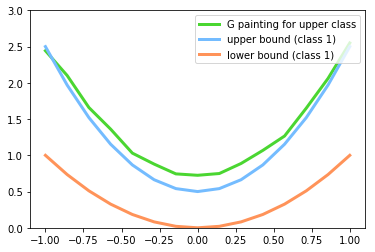

In [29]:
# plot a generated painting for upper class
z= torch.randn(1, N_IDEAS)
label = torch.FloatTensor([[1.]])
G_inputs = torch.cat((z, label), 1)
G_paingings = G(G_inputs)
plt.plot(PAINT_POINTS[0], G_paintings.data.numpy()[0], c='#4AD631', lw=3, label='G painting for upper class')
plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + bound[1], c='#74BCFF', lw=3, label='upper bound (class 1)')
plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + bound[0], c='#FF9359', lw=3, label='lower bound (class 1)')
plt.ylim((0,3));plt.legend(loc='upper right', fontsize=10);plt.show()